# Searching for a similar chain in PDB

Для выполнения задачи выравнивания целевого участка из PDB-файла (`6lzg.pdb`, цепочка `A`, последовательность `KFNHEAEDLFY`) с аналогичными участками в других PDB-файлах (RDB штаммах) используется [swalign](https://github.com/mbreese/swalign).  

1. **Извлечение последовательности из `6lzg.pdb`** (целевой участок `KFNHEAEDLFY` в цепи `A`).  
2. **Для каждого штамма (PDB-файла):**  
   - Загружается его последовательность.  
   - Выполняется **выравнивание**. 
   - Находятся **координаты** участка, наиболее похожего на `KFNHEAEDLFY`.  

In [15]:
rdb_dir_path = "/home/jovyan/protein-protein-docking/data/RBD"
base_structure_path = "/home/jovyan/protein-protein-docking/data/6lzg.pdb"
target_sequence = "KFNHEAEDLFY" # converted from LYSPHEASNHISGLUALAGLUASPLEUPHETYR

In [3]:
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}


def shorten(x):
    if len(x) % 3 != 0: 
        raise ValueError('Input length should be a multiple of three')

    y = ''
    for i in range(len(x) // 3):
        y += d[x[3 * i : 3 * i + 3]]
    return y


def load_structure(pdb_path, chain_id):
    parser = PDBParser()
    structure = parser.get_structure("structure", pdb_path)
    model = structure[0]  # Берём первую модель
    chain = model[chain_id]
    return chain

## MAFFT

In [34]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

In [35]:
# Считаем выравнивание из fasta-файла вручную или с помощью биопитона
def read_fasta(filename):
    sequences = []
    with open(filename, 'r') as f:
        seq = ''
        for line in f:
            if line.startswith('>'):
                if seq:
                    sequences.append(seq)
                    seq = ''
            else:
                seq += line.strip()
        if seq:
            sequences.append(seq)
    return sequences

In [36]:
fasta_file = '/home/jovyan/protein-protein-docking/data/aligned_sequences-BLOSUM62.fasta'
sequences = read_fasta(fasta_file)[30:]

In [37]:
sequences

['----------------------------EERRRLEEERRRLT------',
 '--------------------------TEEERRRLEEERRRREAS----',
 '---------------------------EEERRRLEEERRRRS------',
 '-------------------------SEEEERRRREEEERRRLT-----',
 '----------------------------DERRRREEELRRRLT-----',
 '-------------------------TEEEERRRRELERERERRA----',
 '--------------------------EEEERRRRAA------------',
 '------------------------REEEEERRRRQEELERT-------',
 '---------------------------EEERERRLEEERRRQS-----',
 '----------------------DERLLEEERRRQT-------------',
 '---------------------------EEERRRREEELRRLKS-----',
 '--------------------------REEELRRQEELERQRLLS----',
 '---------------------------EEERRRQEELERQRT------',
 '--------------------------SEEERKRREEEERQRKLA----',
 '--------------------------NEEERKRREEEELAR-------',
 '------------------------TREEEERRRQQELS----------',
 '------------------------EEEERERRRREEEEEREKRT----',
 'VS-----------------LEELEREKEEERRRREES-----------',
 '------------------------SEEEEERLRRERERERAA--

In [38]:
# Длина выравнивания (все последовательности одной длины)
alignment_length = len(sequences[0])

# Подсчет частот аминокислот на каждой позиции
freqs = []
all_aa = sorted(list(set(''.join(sequences))))  # все встречающиеся символы, например ['A', 'C', 'D', ...,'-']

for i in range(alignment_length):
    column = [seq[i] for seq in sequences]
    c = Counter(column)
    total = sum(c.values())
    freqs.append([c[aa] / total for aa in all_aa])

freqs = np.array(freqs).T  # shape: (кол-во аминокислот, длина выравнивания)

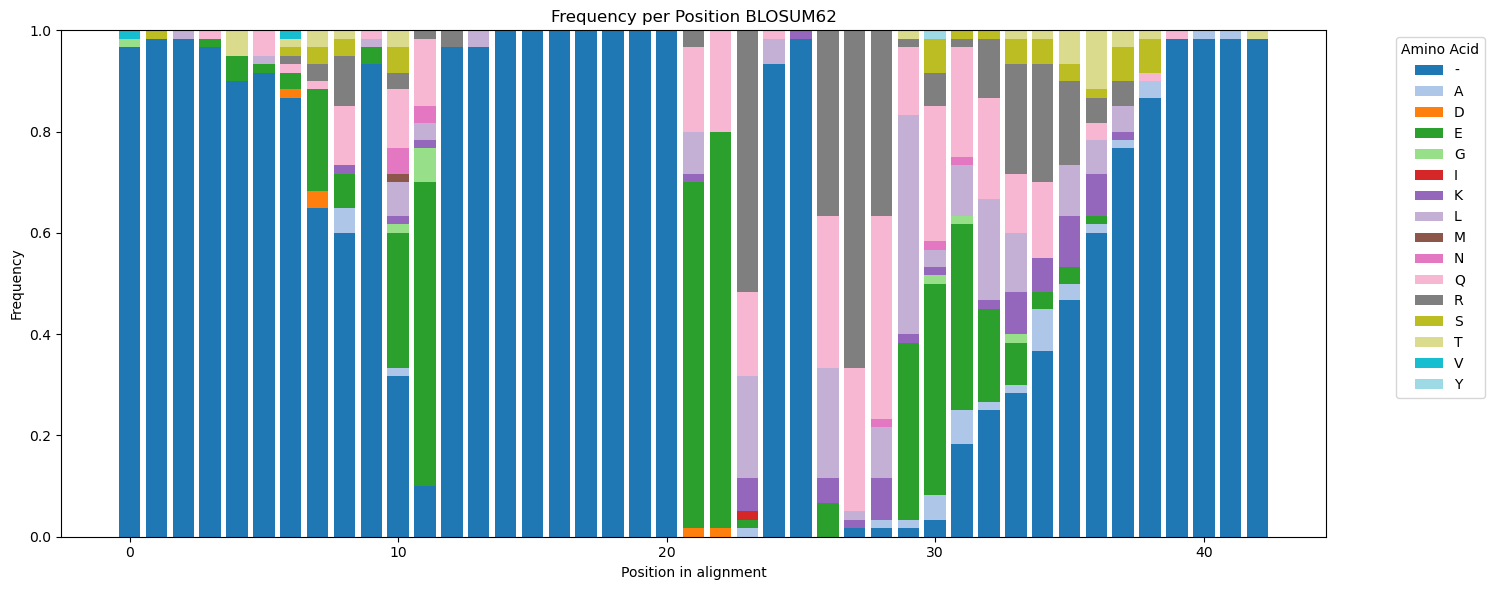

In [44]:
# Построение stacked bar plot
positions = np.arange(alignment_length)
bottom = np.zeros(alignment_length)
cmap = plt.colormaps['tab20']
colors = cmap.resampled(len(all_aa))

plt.figure(figsize=(15, 6))
for i, aa in enumerate(all_aa):
    plt.bar(positions, freqs[i], bottom=bottom, label=aa, color=colors(i))
    bottom += freqs[i]

plt.xlabel('Position in alignment')
plt.ylabel('Frequency')
plt.title('Frequency per Position BLOSUM62')
plt.legend(title='Amino Acid', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [45]:
fasta_file = '/home/jovyan/protein-protein-docking/data/aligned_sequences-JTT100.fasta'
sequences = read_fasta(fasta_file)[30:]

In [46]:
sequences

['---------------------EER--RRLEEERRRLT------',
 '----------TE---------EER--RRLEEERRRREAS----',
 '-----------E---------EER--RRLEEERRRRS------',
 '--------T-EE---------EER--RRRELERERERRA----',
 '----------EE---------EER--RRRAA------------',
 '-------RE-EE---------EER--RRRQEELERT-------',
 '--------S-EE---------EER--RRREEEERRRLT-----',
 '---------------------DER--RRREEELRRRLT-----',
 '-----------E---------EER--ERRLEEERRRQS-----',
 '------DERLLE---------EER--RRQT-------------',
 '-----------E---------EER--RRREEELRRLKS-----',
 '----------RE---------EEL--RRQEELERQRLLS----',
 '-----------E---------EER--RRQEELERQRT------',
 '----------SE---------EER--KRREEEERQRKLA----',
 '----------NE---------EER--KRREEEELAR-------',
 '-------TR-EE---------EER--RRQQELS----------',
 '----------NE---------EEL--RRRQQEEQQRRLS----',
 '-------SE-EE---------EER--LRRERERERAA------',
 '----------EE---------EER--LRQLY------------',
 '-----------E---------EER--LRQLLN-----------',
 '----------GE---------EER--LRRLRG------

In [47]:
# Длина выравнивания (все последовательности одной длины)
alignment_length = len(sequences[0])

# Подсчет частот аминокислот на каждой позиции
freqs = []
all_aa = sorted(list(set(''.join(sequences))))  # все встречающиеся символы, например ['A', 'C', 'D', ...,'-']

for i in range(alignment_length):
    column = [seq[i] for seq in sequences]
    c = Counter(column)
    total = sum(c.values())
    freqs.append([c[aa] / total for aa in all_aa])

freqs = np.array(freqs).T  # shape: (кол-во аминокислот, длина выравнивания)

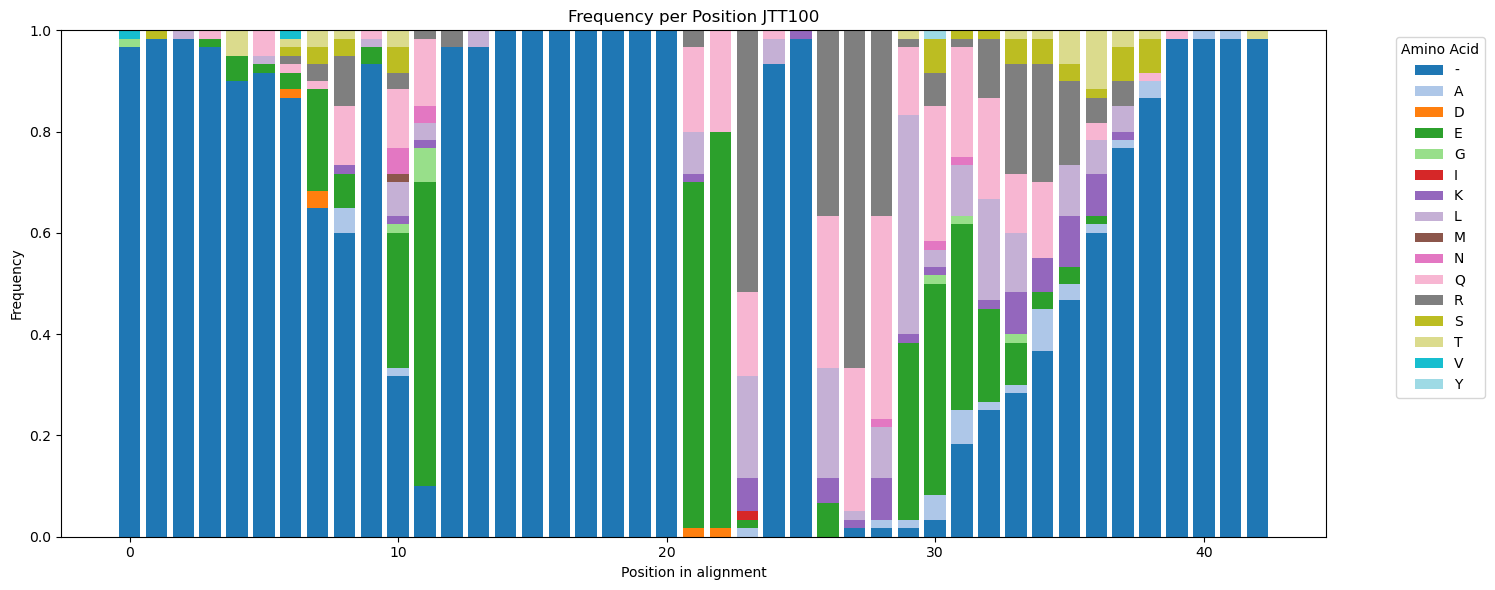

In [48]:
# Построение stacked bar plot
positions = np.arange(alignment_length)
bottom = np.zeros(alignment_length)
cmap = plt.colormaps['tab20']
colors = cmap.resampled(len(all_aa))

plt.figure(figsize=(15, 6))
for i, aa in enumerate(all_aa):
    plt.bar(positions, freqs[i], bottom=bottom, label=aa, color=colors(i))
    bottom += freqs[i]

plt.xlabel('Position in alignment')
plt.ylabel('Frequency')
plt.title('Frequency per Position JTT100')
plt.legend(title='Amino Acid', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Swalign

In [10]:
# !pip install biopython
# !pip install swalign

In [11]:
from glob import glob
import os
# from Bio import Align
from Bio.PDB import PDBParser
# from Bio.Align import substitution_matrices
import pandas as pd
import swalign

In [12]:
parser = PDBParser()
# aligner = Align.PairwiseAligner()
# aligner.mode = 'local' #   global
# aligner.open_gap_score = -1 # штраф за открытие gap
# aligner.extend_gap_score = -2  # штраф за продолжение gap
# # aligner.match_score = 1.0
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

match = 4
mismatch = 3
scoring = swalign.NucleotideScoringMatrix(match, mismatch)
# scoring = swalign.NucleotideScoringMatrix()

sw = swalign.LocalAlignment(scoring)

In [13]:
results = pd.DataFrame(columns=[
    "PDB_File",
    "Chain", 
    "Start_in_Query", 
    "End_in_Query", 
    "Alignment_Score", 
])

for rdb_pdb_path in glob(os.path.join(rdb_dir_path, "*.pdb")):
    chain = load_structure(rdb_pdb_path, "A")
    chain_sequence = "".join([residue.get_resname() for residue in chain])
    alignment = sw.align(target_sequence, shorten(chain_sequence))
    end_in_query = alignment.q_pos + alignment.r_end - alignment.r_pos
    print(f"Файл {os.path.basename(rdb_pdb_path)}: query pos {alignment.q_pos} - {end_in_query}")
    alignment.dump()
    print("-" *15, "\n")
    results.loc[len(results)] = {
        "PDB_File": os.path.basename(rdb_pdb_path),
        "Chain": chain.id,
        "Start_in_Query": alignment.q_pos,
        "End_in_Query": end_in_query,
        "Alignment_Score": alignment.identity
    }
    
    # Выравнивание с целевой последовательностью
    # alignments = aligner.align(target_sequence, shorten(chain_sequence))
    # best_alignment = alignments[0]  # берем лучшее выравнивание
    
    # # Находим координаты выровненного участка
    # start_in_target = best_alignment.aligned[0][0][0]  # Старт в target
    # start_in_query = best_alignment.aligned[1][0][0]   # Старт в query
    # end_in_target = best_alignment.aligned[0][-1][-1]  # Старт в target
    # end_in_query = best_alignment.aligned[1][-1][-1]   # Старт в query
    
    # print(f"Файл {os.path.basename(rdb_pdb_path)}: совпадение с позиции {start_in_query} до {end_in_query}")
    # print(best_alignment.score, best_alignment.length)
    # print(best_alignment)

    # results.loc[len(results)] = {
    #     "PDB_File": os.path.basename(rdb_pdb_path),
    #     "Chain": chain.id,
    #     "Start_in_Query": start_in_query,
    #     "End_in_Query": end_in_query,
    #     "Alignment_Score": best_alignment.score
    # }

results.to_csv("alignment_results.csv", index=False)

Файл RBD_pdb7XBGmutant_unrelaxed_rank_005_alphafold2_ptm_model_1_seed.pdb: query pos 180 - 191
Query: 181 PCSVEGPDCYY 191
           ....|..|..|
Ref  :   1 KFNHEAEDLFY 11

Score: 36
Matches: 3 (27.3%)
Mismatches: 8
CIGAR: 11M
--------------- 

Файл RBD_pdb7F5H_unrelaxed_rank_005_alphafold2_ptm_model_1_seed_000.pdb: query pos 202 - 213
Query: 203 KSTGTLEVLFQ 213
           |.....|.||.
Ref  :   1 KFNHEAEDLFY 11

Score: 37
Matches: 4 (36.4%)
Mismatches: 7
CIGAR: 11M
--------------- 

Файл RBD_UVF39818_unrelaxed_rank_003_alphafold2_ptm_model_4_seed_000.pdb: query pos 180 - 191
Query: 181 GFNCYFPLQSY 191
           .||.......|
Ref  :   1 KFNHEAEDLFY 11

Score: 36
Matches: 3 (27.3%)
Mismatches: 8
CIGAR: 11M
--------------- 

Файл RBD_RSB_7DQA_unrelaxed_rank_005_alphafold2_ptm_model_1_seed_000.pdb: query pos 152 - 163
Query: 153 GFNCYFPLQSY 163
           .||.......|
Ref  :   1 KFNHEAEDLFY 11

Score: 36
Matches: 3 (27.3%)
Mismatches: 8
CIGAR: 11M
--------------- 

Файл RBD_pdb7XBGmutant_unrel

In [14]:
results

,PDB_File,Chain,Start_in_Query,End_in_Query,Alignment_Score
0,RBD_pdb7XBGmutant_unrelaxed_rank_005_alphafold...,A,180,191,0.272727
1,RBD_pdb7F5H_unrelaxed_rank_005_alphafold2_ptm_...,A,202,213,0.363636
2,RBD_UVF39818_unrelaxed_rank_003_alphafold2_ptm...,A,180,191,0.272727
3,RBD_RSB_7DQA_unrelaxed_rank_005_alphafold2_ptm...,A,152,163,0.272727
4,RBD_pdb7XBGmutant_unrelaxed_rank_003_alphafold...,A,180,191,0.272727
5,RBD_RSB_7WBL_unrelaxed_rank_004_alphafold2_ptm...,A,152,163,0.272727
6,RBD_pdb7XBGmutant_unrelaxed_rank_001_alphafold...,A,180,191,0.272727
7,RBD_rbdKFU_unrelaxed_rank_001_alphafold2_ptm_m...,A,208,219,0.272727
8,RBD_RSB_6M0J_unrelaxed_rank_001_alphafold2_ptm...,A,166,177,0.272727
9,RBD_RSB_7WBL_unrelaxed_rank_001_alphafold2_ptm...,A,152,163,0.272727


## Bio.SVDSuperimposer package

In [1]:
# !pip install biopython

In [4]:
from Bio.PDB import PDBParser, Superimposer
from Bio.PDB.PDBIO import PDBIO
import numpy as np
from glob import glob
import os
import pandas as pd

In [5]:
def get_ca_atoms(chain, residue_range):
    return [res['CA'] for res in chain if res.id[1] in residue_range]

In [19]:
MOVING_PDB = glob(os.path.join(rdb_dir_path, "*.pdb"))[0]   # Структура для выравнивания
CHAIN_FIX = "A"             # Цепь в референсной структуре
CHAIN_MOV = "A"             # Цепь в подвижной структуре

# Выбираем ВСЕ остатки
RES_RANGE_FIX = range(31, 41)  # Диапазон остатков в референсе
RES_RANGE_MOV = range(1, 243)   # Диапазон остатков в подвижной структуре

# Загрузка структур
chain_fix = load_structure(base_structure_path, CHAIN_FIX)
chain_mov = load_structure(MOVING_PDB, CHAIN_MOV)

/opt/conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13519.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13605.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 13633.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:100: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 13898.
  warnings.warn(


In [22]:
fixed_residues = [res.id[1] for res in chain_fix if res.id[0] == ' ']
moving_residues = [res.id[1] for res in chain_mov if res.id[0] == ' ']

# Убедитесь, что количество остатков совпадает!
if len(fixed_residues) != len(moving_residues):
    raise ValueError(f"Количество остатков в цепях разное! {len(fixed_residues)}, {len(moving_residues)}")

RES_RANGE_FIX = fixed_residues  # Все остатки фиксированной структуры
RES_RANGE_MOV = moving_residues  # Все остатки подвижной структуры

ValueError: Количество остатков в цепях разное! 596, 242

In [ ]:
atoms_fix = get_ca_atoms(chain_fix, RES_RANGE_FIX)
atoms_mov = get_ca_atoms(chain_mov, RES_RANGE_MOV)

if len(atoms_fix) != len(atoms_mov):
    raise ValueError(f"Несовпадение количества остатков: {len(atoms_fix)} vs {len(atoms_mov)}")

sup = Superimposer()
sup.set_atoms(atoms_fix, atoms_mov)  # Фиксируем, накладываем подвижные
sup.apply(chain_mov.get_parent().get_parent().get_atoms())  # Применяем ко ВСЕМ атомам подвижной структуры

io = PDBIO()
io.set_structure(chain_mov.get_parent().get_parent())
io.save("aligned.pdb")

print(f"RMSD после выравнивания: {sup.rms:.3f} Å")
print("Наложенная структура сохранена в aligned.pdb")